# Forensic POS Data Analysis

$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

### Backgound & Objective
In 2006, a group of Americans invested in a company that claimed it went out of buisness shortly after receiving funds from the group.  This company sold and serviced point-of-sales (POS) equipment such as credit and debit card processing machines to small and medium sized merchants throughout Canada.  The information the Americans collected as a part of their due diligence suggested that the company they had invested in had substantial assets and cashflow, but that the president of the company was attempting to avoid paying back the investors in spite of having the means to do so.

In 2007, the Americans obtained a [judgment against the company](https://github.com/MichaelSzczepaniak/FraudulentConveyance/blob/master/Judgment%20%28redacted%29.pdf) and conducted a [judgment debtor examination (JDE)](https://www.attorneygeneral.jus.gov.on.ca/english/courts/guides/After_Judgement_Guide_to_Getting_Results_EN.html#_Toc436642217) with the president.  One of the undertakings from the JDE was for the president of the company to provide data showing the monthly account activity for all the merchants and terminals the company had in its portfolio over a given time period.

The purpose of this analysis was to investigate the likelihood that [fraudulant conveyance](https://en.wikipedia.org/wiki/Fraudulent_conveyance) had occurred.  This was originally done in Java.  The data being analyzed in this notebook was taken from the actual legal action that spanned from 2007 through 2013 utilizing a port of the original Java code over to Python.

### Data
The data was originally provided as a collection of Microsoft Word files which were converted to and saved as straight ASCII text files to simplify the analysis.  Each of these data files can be found [here](https://github.com/MichaelSzczepaniak/FraudulentConveyance/tree/master/data/rawOsMerchantReportsTxt).  These text files are the raw data from which the [preprocessing](https://www.techopedia.com/definition/14650/data-preprocessing) and the subsequent analysis was conducted.

### Preprocessing
As with most data analysis projects, most of the work involved preprocessing the data to get it into a usable form.  The first step was to see what this data looked like.  Start by looking at the first few lines of the first data file.

In [41]:
import urllib.request
data_url = "https://raw.githubusercontent.com/MichaelSzczepaniak/FraudulentConveyance/master/data/rawOsMerchantReportsTxt/07P_401.txt"

with urllib.request.urlopen(data_url) as response:
   response_data = str(response.read(),'utf-8')

response_data[:100]

'\tTo:\tNCE NEW CANASIAN ENT INC\tContact: CHRIS GREEN, Phone: 613-722-7797, Fax:   \n\tHARVEST LOAF, 1323'

The response from the *urlopen* request is just a big bucket of bytes which is converted to a big string with no line breaks.  So to make this data easier to work with, we'll split this sting into an array of strings.

In [52]:
report_as_lines = data.split("\n")
print("\n".join(report_as_lines[:18]))
print("...")
print("\n".join(report_as_lines[48:67]))
print("...")

	To:	NCE NEW CANASIAN ENT INC	Contact: CHRIS GREEN, Phone: 613-722-7797, Fax:   
	HARVEST LOAF, 1323 WELLINGTON
	OTTAWA, ON,  K1Y 3B6	Time Zone:  Eastern Time 
	Merchant: 07P282          Site:   07P28201

	Terminal: 07P10008

	MONTHLY SETTLEMENT

	Date	Batch #	Complete #	Incomplete #	Approved
	User Fee	Purchase 
	Haulage Fee	Haulage Fee	Merchant

	Transaction 
	Collected Daily	Settlement

	01/02	1	4	0	33.91	1.00	32.91	0.70	0.00	32.91
	01/03	1	6	0	30.88	1.50	29.38	1.05	0.00	29.38
...

	To:	DAVIS J CATT	Contact: DAVID OR VICKY, Phone: 705-734-0755, Fax:   
	ANNSDALE SMALL ENGINES, 181 BROCK ST
	BARRIE, ON,  L4N 2M3	Time Zone:  Eastern Time 
	Merchant: 07P257          Site:   07P25701

	Terminal: 07P10200

	MONTHLY SETTLEMENT

	Date	Batch #	Complete #	Incomplete #	Approved
	User Fee	Purchase 
	Haulage Fee	Haulage Fee	Merchant

	Transaction 
	Collected Daily	Settlement

	01/06	1	1	0	118.65	0.25	118.40	0.18	0.00	118.40
	01/07	1	1	0	46.20	0.25	45.95	0.18	0.00	45.95
...


Now this is starting to look more understandable.  From here, we need to break out the sections assigned to each merchant.  I call the sections representing each merchant **raw merchant records** and use the following function to parse the out.

In [55]:
# Initialize some constants
toToken = "To"
contactToken = "Contact:"
phoneToken = "Phone:"
faxToken = "Fax:"
timeZoneToken = "Time Zone:"
merchantToken = "Merchant:"
siteToken = "Site:"
terminalToken = "Terminal:"
dateToken = "Date"

def getRawMerchantRecords(lines):
    """ Parses a list of strings into another list of strings where each
    inner list are lines related to individual merchants.
    
    lines - list of strings containing information on a set of merchants
            for a given month
    
    Precondition: It's assumed that each merchant record starts with a line:
    To: <merchant name>
    and ends with 3 consecutive blank lines.
    
    """
    raw_records = []
    record = []
    build_record = False
    blank_lines = 0
    print("getRawMerchantRecords: number of lines = ", len(lines))
    for i in range(len(lines)):
        line = lines[i].strip()  # Remove leading white space
        if line.startswith(toToken):
            build_record = True
            record = [line, ]    # Add first line of new record
        elif len(line.strip()) < 1:      # At a blank line?
            blank_lines += 1
            # Last line of current record?
            if blank_lines >= 3:
                if build_record:
                    raw_records.append(record[:])
                    build_record = False
                    blank_lines = 0
        elif build_record:
            record.append(line)
            blank_lines = 0
            
    return raw_records

raw_merchants = getRawMerchantRecords(report_as_lines)
# Test to see that we have data for a single merchant in each element.
print("\n".join(raw_merchants[0]))
print("--------------------------------------------------------------------")
print("\n".join(raw_merchants[1]))
print("...")

getRawMerchantRecords: number of lines =  6699
To:	NCE NEW CANASIAN ENT INC	Contact: CHRIS GREEN, Phone: 613-722-7797, Fax:
HARVEST LOAF, 1323 WELLINGTON
OTTAWA, ON,  K1Y 3B6	Time Zone:  Eastern Time
Merchant: 07P282          Site:   07P28201
Terminal: 07P10008
MONTHLY SETTLEMENT
Date	Batch #	Complete #	Incomplete #	Approved
User Fee	Purchase
Haulage Fee	Haulage Fee	Merchant
Transaction
Collected Daily	Settlement
01/02	1	4	0	33.91	1.00	32.91	0.70	0.00	32.91
01/03	1	6	0	30.88	1.50	29.38	1.05	0.00	29.38
01/04	1	7	0	70.41	1.75	68.66	1.23	0.00	68.66
01/05	1	2	0	15.51	0.50	15.01	0.35	0.00	15.01
01/06	1	3	0	36.48	0.75	35.73	0.53	0.00	35.73
01/07	1	2	0	17.80	0.50	17.30	0.35	0.00	17.30
01/08	1	1	0	4.98	0.25	4.73	0.18	0.00	4.73
01/09	1	4	1	61.38	1.00	60.38	0.75	0.00	60.38
01/10	1	8	3	103.97	2.00	101.97	1.55	0.00	101.97
01/11	1	3	0	24.64	0.75	23.89	0.53	0.00	23.89
01/12	1	2	0	6.75	0.50	6.25	0.35	0.00	6.25
01/13	1	2	0	11.15	0.50	10.65	0.35	0.00	10.65
01/14	1	4	0	53.52	1.00	52.52	0.70	0.00	52.52
0

Looks good, but this is still tough to work with.  It would be great to parse this into some kind of object and persist those objects in a database so that they can be easily retrieved later.  When I did a lot of Java, we call this a "bean".  In this case, this is little more than a clean way to encapsulate a monthly merchant report data chunk.

In [56]:
class OsMerchantReportRecord:
    def __init__(self, os_report_dict, os_merchant_dict):
        ## info extracted from file name
        self._isoNum = os_report_dict['isoNum']
        self._reportYear = os_report_dict['reportYear']
        self._reportMonth = os_report_dict['reportMonth']
        ## info extracted from reports
        self._busName = os_merchant_dict['busName']
        self._corpName = os_merchant_dict['corpName']
        self._contact = os_merchant_dict['contact']
        self._phone = os_merchant_dict['phone']
        self._address = os_merchant_dict['address']
        self._city = os_merchant_dict['city']
        self._province = os_merchant_dict['province']
        self._postalCode = os_merchant_dict['postalCode']
        self._timeZone = os_merchant_dict['timeZone']
        self._merchantId = os_merchant_dict['merchantId']
        self._siteId = os_merchant_dict['siteId']
        self._terminalId = os_merchant_dict['terminalId']
        
    #### All we need are getters because all instance variables
    #### should never change after instantiation.
    def getIsoNum(self):
        return self._isoNum
        
    def getMonth(self):
        return self._reportMonth
        
    def getYear(self):
        return self._reportYear
        
    def getBusName(self):
        return self._busName
        
    def getCorpName(self):
        return self._corpName
        
    def getContact(self):
        return self._contact
        
    def getPhone(self):
        return self._phone
    
    def getAddress(self):
        return self._address
        
    def getCity(self):
        return self._city
        
    def getProvince(self):
        return self._province
        
    def getPostalCode(self):
        return self._postalCode
        
    def getTimeZone(self):
        return self._timeZone
        
    def getMerchantId(self):
        return self._merchantId
        
    def getSiteId(self):
        return self._siteId
        
    def getTerminalId(self):
        return self._terminalId
    
    def asTuple(self):
        osm_tuple = (self._busName, self._corpName, self._contact,
                     self._phone, self._address, self._city,
                     self._province, self._postalCode, self._timeZone,
                     self._merchantId, self._siteId, self._terminalId,
                     self._isoNum, self._reportYear, self._reportMonth)
                       
        return osm_tuple
    
    def toString(self):
        osm_fields = []
        for item in self.asTuple():
            osm_fields.append(str(item))
        
        return ",".join(osm_fields)

In [18]:
data = pd.read_csv("../data/OsMerchantTerminalDropsAdds.csv")
d1 = data.loc[1:29]  # pre-trouble
d2 = data.loc[30:35] # stopped making payments
d3 = data.loc[36:]   # legal action

(100, 900)

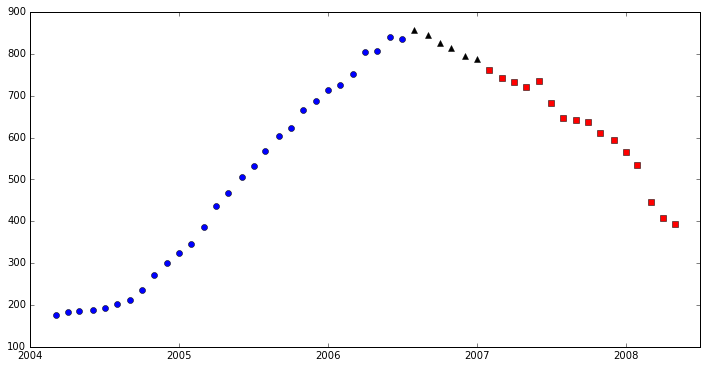

In [19]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
width=12; height=6
plt.figure(figsize=(width, height))
# http://stackoverflow.com/questions/12608788/
ax = plt.gca()
x_formatter = mp.ticker.ScalarFormatter(useOffset=False)
ax.xaxis.set_major_formatter(x_formatter)
plt.xticks(np.arange(2004, 2008.5, 1.0))

data = pd.read_csv("../data/OsMerchantTerminalDropsAdds.csv")
d1 = data.loc[1:29]
d2 = data.loc[30:35]
d3 = data.loc[36:]
plt.plot(d1['yearFrac'], d1['merchantCount'], 'bo')
plt.plot(d2['yearFrac'], d2['merchantCount'], 'k^')
plt.plot(d3['yearFrac'], d3['merchantCount'], 'rs')
plt.xlim([2004,2008.5])
plt.ylim([100, 900])

(0, 0.2)

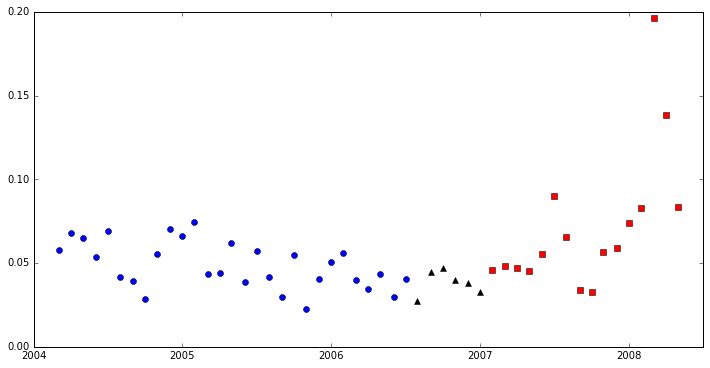

In [20]:
width=12; height=6
plt.figure(figsize=(width, height))
plt.xticks(np.arange(2004, 2008.5, 1.0))
ax = plt.gca()
x_formatter = mp.ticker.ScalarFormatter(useOffset=False)
ax.xaxis.set_major_formatter(x_formatter)

plt.plot(d1['yearFrac'], d1['merchant_drop_rate'], 'bo')
plt.plot(d2['yearFrac'], d2['merchant_drop_rate'], 'k^')
plt.plot(d3['yearFrac'], d3['merchant_drop_rate'], 'rs')
plt.xlim([2004,2008.5])
plt.ylim([0, 0.2])

As has been derived in countless textbooks, the linear least squares equation for $\wv$ can be written in matrix form as

$\Xv^T \Xv \wv = \Xv^T \Tv$

There are several ways to solve for $\wv$, but I'll use the *lstsq* function because it does not assume linearly independent matrix columns. 

    w = np.linalg.lstsq(np.dot(X.T,X), np.dot(X.T, T))

In [21]:
# h(orizontal )stack(ing): like cbind in r...
X1 = np.hstack((np.ones((d1['yearFrac'].shape[0],1)), X))
xtx = np.dot(X1.T, d1['yearFrac'])
xtx
#w1 = np.linalg.lstsq(np.dot(d1['yearFrac'].T, d1['yearFrac']),
#                     np.dot(d1['yearFrac'].T, d1['merchant_drop_rate']))
#w1

140782795.90220001